## European style Premier League football betting odds

#### Author: Petar Sarajcev, PhD; University of Split, FESB, Croatia. (petar.sarajcev@fesb.hr)

This post is heavily influenced and reuses code from the following blog post:

http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/

Hierarchical Bayesian Model is based on the following paper:

http://docs.pymc.io/notebooks/www.statistica.it/gianluca/Research/BaioBlangiardo.pdf

In [1]:
from __future__ import print_function

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

import theano.tensor as tt
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
sns.set(context='notebook', style='darkgrid', font_scale=1.2)

### Using games data from the last two seasons: 2016 - 2017 and 2015 - 2016.

#### Season 2016 - 2017 games data

Premier League data for the 2016 - 2017 season is awailable here:

https://en.wikipedia.org/wiki/2016–17_Premier_League

In [7]:
data_17 = pd.read_csv('premier_2016-17.csv', sep='\t', index_col=0, encoding='utf-8')

#### Season 2015 - 2016 games data

Premier League data for the 2015 - 2016 season is awailable here:

https://en.wikipedia.org/wiki/2015–16_Premier_League

In [8]:
data_16 = pd.read_csv('premier_2015-16.csv', sep='\t', index_col=0, encoding='utf-8')

In [9]:
def process_season_table(data):
    rows = []
    for i in range(len(data.index)):
        for j in range(len(data.columns)):
            if i == j:
                continue
            cell = data.iloc[i,j]
            score = [int(k) for k in cell.split(u'\u2013')]
            rows.append([data.columns[i], data.columns[j], score[0], score[1]])
    df = pd.DataFrame(rows, columns=['home', 'away', 'home_s', 'away_s'])
    return df

In [10]:
df_17 = process_season_table(data_17)

In [11]:
df_16 = process_season_table(data_16)

In [12]:
teams_17 = data_17.columns.values
teams_17 = pd.DataFrame(teams_17, columns=['team'])
teams_17['name'] = data_17.index
teams_16 = data_16.columns.values
teams_16 = pd.DataFrame(teams_16, columns=['team'])
teams_16['name'] = data_16.index

#### Team names and short notation (from both seasons)

In [13]:
teams = pd.merge(left=teams_17, right=teams_16, how='outer', on='team')
teams['name'] = teams['name_x'].fillna(teams['name_y'], inplace=True)
teams = teams.drop(labels=['name_y', 'name'], axis=1)
teams = teams.rename(columns={'name_x':'name'})
teams['i'] = teams.index
teams

,team,name,i
0,ARS,Arsenal,0
1,BOU,Bournemouth,1
2,BUR,Burnley,2
3,CHE,Chelsea,3
4,CRY,Crystal Palace,4
5,EVE,Everton,5
6,HUL,Hull City,6
7,LEI,Leicester City,7
8,LIV,Liverpool,8
9,MCI,Manchester City,9


In [14]:
df_17 = pd.merge(df_17, teams_17, left_on='home', right_on='team', how='left')
df_16 = pd.merge(df_16, teams_16, left_on='home', right_on='team', how='left')

In [15]:
df = pd.concat([df_17, df_16])

In [16]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns={'i':'home_i'})
df = df.drop(labels=['team_x', 'name_x', 'team_y', 'name_y'], axis=1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns={'i':'away_i'})
df = df.drop(labels=['team'], axis=1)

In [17]:
# make a copy at this point for further reference
df_freeze = df.copy()

In [18]:
def home_outcome(home, away):
    if home == np.NaN or away == np.NaN:
        outcome = np.NaN
    else:
        if home > away:
            outcome = 'win'
        elif home < away:
            outcome = 'loss'
        else:
            outcome = 'draw'
    return outcome

def away_outcome(home, away):
    if home == np.NaN or away == np.NaN:
        outcome = np.NaN
    else:
        if home < away:
            outcome = 'win'
        elif home > away:
            outcome = 'loss'
        else:
            outcome = 'draw'
    return outcome    

In [19]:
df['home_outcome'] = df.apply(lambda x: home_outcome(x['home_s'], x['away_s']), axis=1)
df['away_outcome'] = df.apply(lambda x: away_outcome(x['home_s'], x['away_s']), axis=1)
df = df.join(pd.get_dummies(df['home_outcome'], prefix='home'))
df = df.join(pd.get_dummies(df['away_outcome'], prefix='away'))

In [20]:
obs_home_gols = df['home_s'].values
obs_away_gols = df['away_s'].values
home_team = df['home_i'].values
away_team = df['away_i'].values
num_teams = len(teams['i'].values)
num_games = len(df.index)

### Hierarchical Bayesian Model with Two groups (top teams and the rest)

In [26]:
with pm.Model() as model2:
    # Hyper-parameters
    home = pm.Normal('home', mu=0., tau=0.0001)
    tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1, shape=2)
    tau_def = pm.Gamma('tau_def', alpha=0.1, beta=0.1, shape=2)
    BoundedNormalLow = pm.Bound(pm.Normal, lower=-3., upper=0.)
    BoundedNormalHig = pm.Bound(pm.Normal, lower=0., upper=3.)
    mu_att1 = BoundedNormalHig('mu_att1', mu=0., tau=0.001)  # TOP 
    mu_def1 = BoundedNormalLow('mu_def1', mu=0., tau=0.001)  # TEAMS
    mu_att2 = pm.Normal('mu_att2', mu=0., tau=0.0001)  # THE
    mu_def2 = pm.Normal('mu_def2', mu=0., tau=0.0001)  # REST
    # Separate group indicators for attacking and defending capability for each team
    grp_att = pm.Categorical('grp_att', p=np.asarray([0.5, 0.5]), shape=num_teams)
    grp_def = pm.Categorical('grp_def', p=np.asarray([0.5, 0.5]), shape=num_teams)
    mu_att = pm.Deterministic('mu_att', tt.as_tensor_variable([mu_att1, mu_att2]))
    mu_def = pm.Deterministic('mu_def', tt.as_tensor_variable([mu_def1, mu_def2]))  
    # Team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=mu_att[grp_att], tau=tau_att[grp_att], shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=mu_def[grp_def], tau=tau_def[grp_def], shape=num_teams)
    # Reparameterization
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    # Model
    home_theta = tt.exp(home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(atts[away_team] + defs[home_team])
    # Likelihoods of the observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=obs_home_gols)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=obs_away_gols)
    # MCMC
    chain = pm.sample(draws=20000, tune=2000, nuts_kwargs={'target_accept':0.95},
                      discard_tuned_samples=True)

Assigned NUTS to home
Assigned NUTS to tau_att_log__
Assigned NUTS to tau_def_log__
Assigned NUTS to mu_att1_interval__
Assigned NUTS to mu_def1_interval__
Assigned NUTS to mu_att2
Assigned NUTS to mu_def2
Assigned BinaryGibbsMetropolis to grp_att
Assigned BinaryGibbsMetropolis to grp_def
Assigned NUTS to atts_star
Assigned NUTS to defs_star
100%|██████████| 22000/22000 [07:35<00:00, 48.26it/s]


In [27]:
burn = 0; thin = 1  # burn-in & thinning
trace2 = chain[burn::thin]

In [28]:
var_names2 = ['grp_att', 'grp_def', 'atts', 'defs']

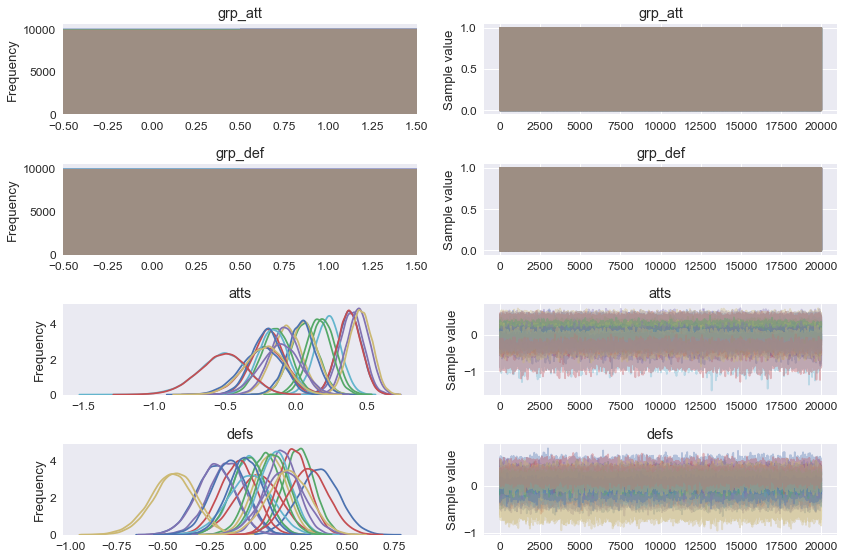

In [29]:
pm.traceplot(trace2, varnames=var_names2);

### Simulate games between teams

In [31]:
# Simulate season from the original model
def simulate_one_season(trace, df):
    num_samples = trace['defs'].shape[0]
    # Draw a single set of parameters from the trace
    draw = np.random.randint(0, num_samples)
    home = trace['home'][draw]
    atts = trace['atts'][draw]
    atts_draw = pd.DataFrame({'att':atts})
    defs = trace['defs'][draw]
    defs_draw = pd.DataFrame({'def':defs})
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='home_i', right_index=True)
    season = pd.merge(season, defs_draw, left_on='home_i', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='away_i', right_index=True)
    season = pd.merge(season, defs_draw, left_on='away_i', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home_val'] = home
    season['home_theta'] = season.apply(lambda x: np.exp(x['home_val'] + 
                                        x['att_home'] + x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: np.exp(x['att_away'] + x['def_home']), axis=1)        
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: home_outcome(x['home_goals'], x['away_goals']), axis=1)
    season['away_outcome'] = season.apply(lambda x: away_outcome(x['home_goals'], x['away_goals']), axis=1)
    season = season.join(pd.get_dummies(season['home_outcome'], prefix='home'))
    season = season.join(pd.get_dummies(season['away_outcome'], prefix='away'))
    return season

In [32]:
# Simulate large number of games between two teams
def simulate_games(home, away, trace, num_simul=100):
    outcome = {'win':0, 'loss':0, 'draw':0}
    for k in range(num_simul):
        s = simulate_one_season(trace, df_freeze)  # trace from the model
        h = s[(s['home']==home) & (s['away']==away)]
        outcome['win']  += h['home_win'].values[0]
        outcome['loss'] += h['home_loss'].values[0]
        outcome['draw'] += h['home_draw'].values[0]
    for key in outcome.keys():
        outcome[key] = float(outcome[key])/num_simul
        outcome[key] = 1./outcome[key]  # odds
    return outcome

### Computing betting coefficients or odds (European style)

In [33]:
# Arsenal is playing at home against the Newcastle
# Arsenal has the home field advantage
home_team = 'ARS'
away_team = 'NEW'
coeffs = simulate_games(home_team, away_team, trace2, 1000)  # 1000 simulated games
# Betting odds
coeffs

{'draw': 6.024096385542168,
 'loss': 12.195121951219512,
 'win': 1.3297872340425532}

Comparison between the computed betting odds and the actual offer from the bookmaker:

|  1   |  X   |  2    | **Arsenal vs Newcastle**
|------|------|-------|
| 1,25 | 5,30 | 12,00 | Prva sportska kladionica (www.psk.hr) with ~7.2% margin
| 1.33 | 6.02 | 12.20 | Simulation using actual probability without the margin

In [34]:
# Everton is playing at home against the Swansea City
# Everton has the home field advantage
home_team = 'EVE'
away_team = 'SWA'
coeffs = simulate_games(home_team, away_team, trace2, 1000)  # 1000 simulated games
# Betting odds
coeffs

{'draw': 4.975124378109452,
 'loss': 6.172839506172839,
 'win': 1.5698587127158556}

Comparison between the computed betting odds and the actual offer from the bookmaker:

|  1   |  X   |  2   | **Everton vs Swansea City**
|------|------|------|
| 1,75 | 3,50 | 4,70 | Prva sportska kladionica (www.psk.hr) with ~7% margin
| 1.57 | 4.98 | 6.17 | Simulation using actual probability without the margin

The bookmakers at the PSK are offering coefficient on the Everton winning against the Swansea that is higher than the coefficient (obtained from the actual probability) predicted by the model. This means that they are (according to this model) underrating the probability of the Everton winning against the Swansea at home. If one wishes to trust the model on this prediction, one may want to put some money on this outcome?

**Disclaimer**: This notebook is furnished "as is". The author does not provide any warranty whatsoever, whether express, implied, or statutory, including, but not limited to, any warranty of merchantability or fitness for a particular purpose or any warranty that the contents of the notebook will be error-free. In no respect shall the author incur any liability for any damages resulting from, or in any way connected to the use of the notebook material, whether or not loss was sustained from, or arose out of, the usage of the results of the notebook material.